# Carte de contrôle

## 0 - Connexion a la BDD

In [348]:
import psycopg
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy
from datetime import timedelta, datetime


# Connexion settings
conn_settings = {
  "host": "localhost",
  "dbname": "db",
  "user": "postgres",
  "password": "patate360",
  "port": 5432
}

conn = psycopg.connect(**conn_settings)

idSensor = 1 # Constant to select the sensor

In [349]:
# Check if the sensor exists in the database
sql = """
SELECT * FROM Sensor WHERE sensorid = %(id)s 
"""

param = {"id": idSensor}

with conn.execute(sql, param) as cur:
  row = cur.fetchone()
  if(row == None):
    raise Exception("No sensor associated with this id")

## 1 - Cartes de contrôle

In [350]:
# Get the last manual measurement for the selected sensor
def getLastMeasure(): 
  sql = """
  SELECT max(controltimestamp) FROM controlMeasurement
  WHERE sensorid = %(id)s 
  """

  param = {"id": idSensor}

  with conn.execute(sql, param) as cur:
    return cur.fetchone()[0]

In [351]:
# Get the error values for the last 8 days up to a limit of 100 items, 
# and if the number of items is less than 20, extend the period bayond 8 days.
# Each error value is associated with the time the measurements were made
def getDataControlCard(): 
  # Used to retrieve values within an 8 days interval from the last measurement
  limitDays = getLastMeasure() - timedelta(days = 8)

  sql = """
  SELECT controlValue - sensorValue, cm.controltimestamp
  FROM ControlMeasurement cm
  JOIN SensorMeasurement sm ON cm.sensorid = sm.sensorid AND cm.sensortimestamp = sm.timestamp
  WHERE cm.sensorid = %(id)s
  ORDER BY cm.controltimestamp DESC
  LIMIT 100
  """

  param = {"id": idSensor}

  with conn.execute(sql, param) as cur:
    rows = []
    line = cur.fetchone()
    
    # Guarantee that we have at least 20 values to display
    while(line != None and (len(rows) < 20 or line[1] >= limitDays)):
      rows.append(line)
      line = cur.fetchone()

    # Reverse the list to have the data in the correct order
    rows.reverse()
    return rows

In [352]:
# Get the average of the erreur values
def getMeanErrorValue():
  sql = """
    SELECT avg(controlValue - sensorValue)
    FROM ControlMeasurement cm
    JOIN SensorMeasurement sm ON cm.sensorid = sm.sensorid AND cm.sensortimestamp = sm.timestamp
    WHERE cm.sensorid = %(id)s;
  """

  param = {"id": idSensor}

  with conn.execute(sql, param) as cur:
    return cur.fetchone()[0]

In [353]:
# Get the stddev of the erreur values
def getStddevErrorValue():
  sql = """
    SELECT stddev(controlValue - sensorValue)
    FROM ControlMeasurement cm
    JOIN SensorMeasurement sm ON cm.sensorid = sm.sensorid AND cm.sensortimestamp = sm.timestamp
    WHERE cm.sensorid = %(id)s;
  """

  param = {"id": idSensor}

  with conn.execute(sql, param) as cur:
    return cur.fetchone()[0]

In [354]:
# Show control chart
def showControlCard():
  # Get data needed for display
  data = getDataControlCard()
  mean = getMeanErrorValue()
  stddev = getStddevErrorValue()

  # Format the data
  x = []
  y = []
  for el in data:
    y.append(el[0])
    x.append(el[1])

  # Show Data
  plt.figure(figsize=(12, 8))
  plt.plot(x, y, label='Datas')
  plt.plot([data[0][1], data[-1][1]], [mean, mean], label='Average')
  plt.plot([data[0][1], data[-1][1]], [mean + 2 * stddev, mean + 2 * stddev], c="Red", lw=2, label='Upper Control Limit')
  plt.plot([data[0][1], data[-1][1]], [mean - 2 * stddev, mean - 2 * stddev], c="Black", lw=2, label='Lower Control Limit')
  
  # Cosmetic
  plt.title('Control Chart')
  plt.xlabel('Time')
  plt.ylabel('Error measurement')
  plt.legend(bbox_to_anchor=(1, 1)) # Place the legend outside the chart
  plt.xticks(rotation=30) # For better readability

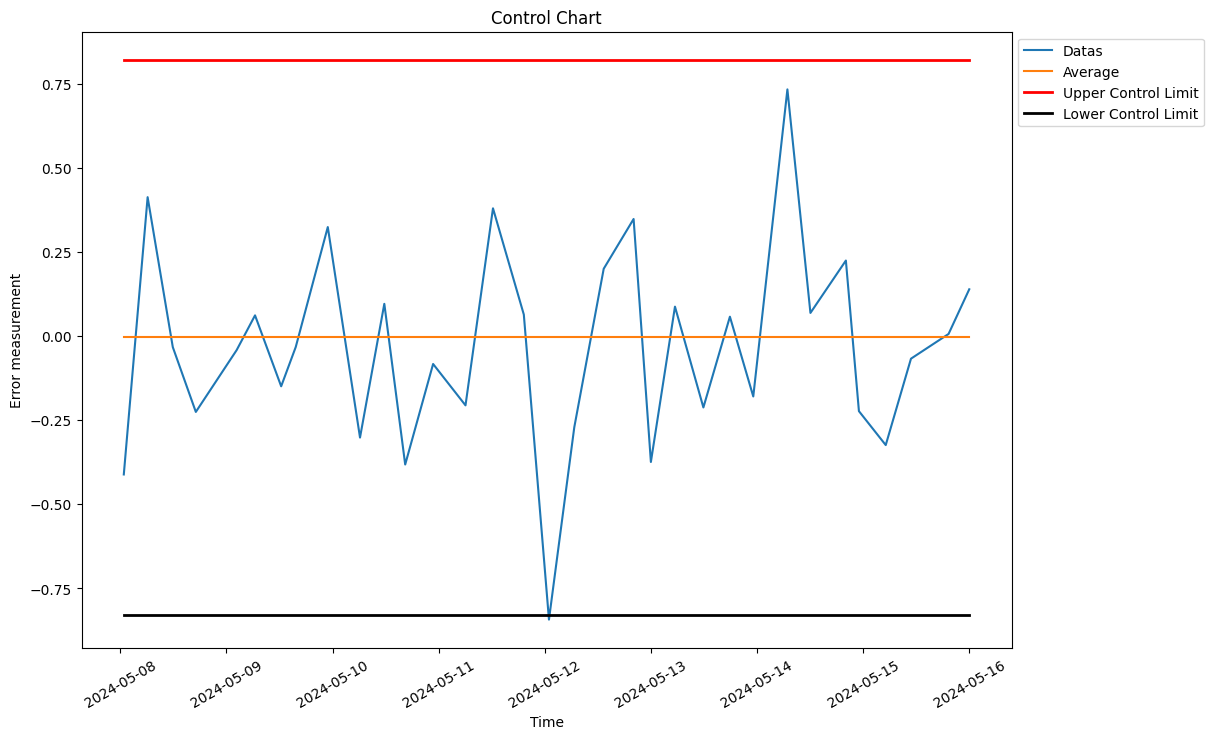

In [355]:
showControlCard()

## 2 - Statistiques
### 2.1 - Visualisation des marges d'erreur

In [356]:
# Get error values from the database
def getErrorValues():
  sql = """
    SELECT controlValue - sensorValue
    FROM ControlMeasurement cm
    JOIN SensorMeasurement sm ON cm.sensorid = sm.sensorid AND cm.sensortimestamp = sm.timestamp
    WHERE cm.sensorid = %(id)s
  """

  param = {"id": idSensor}

  with conn.execute(sql, param) as cur:
    return [row[0] for row in cur]

In [357]:
# Calculate the distribution of values in a data set based on intervals defined by multiples of the standard deviation.
def getDistributionByStdIntervals(data, factor):
  # Initialize a list of counters. The indexes correspond to intervals defined by multiples of the standard deviation.
  # The structure is organized as follows:
  # [ [-σ; 0], ]0; σ], ...,  [-factor*σ; -(factor+1)*σ[, ](factor-1)*σ; factor*σ], < -factor*σ, > factor*σ ]
  counts = [0 for _ in range(factor * 2 + 2)]

  std_dev = numpy.std(data)

  # Loops through the data values to distribute them into the corresponding intervals.
  for value in data:
    # Determines the index of the interval corresponding to the value based on the standard deviation.
    # The interval is calculated by taking the absolute value divided by the standard deviation.
    interval_index = int(abs(value) // std_dev)
    # Corrects the index to avoid errors due to exact divisions (if the value is a multiple of the standard deviation).
    if(abs(value) % std_dev == 0 and value != 0):
      interval_index -= 1

    # Updates the counter corresponding to the interval.
    # If the index exceeds the limit define by "factor", increment the counter of out-of-bounds values.
    if (interval_index >= factor):
      counts[-1 if value > 0 else -2] += 1
    else:
      counts[interval_index * 2 + (1 if value > 0 else 0)] += 1

  # Converts counts to percentages of the total data.
  # Organize the results in the following order:
  # [< -factor*σ, [-factor*σ; -(factor+1)*σ[, ..., [-σ; 0], ]0; σ], ..., ](factor-1)*σ; factor*σ], > factor*σ]
  percentages = []
  for i in range(len(counts) - 2, -1, -2):
    percentages.append(round(counts[i] / len(data) * 100, 2))
  for i in range(1, len(counts), 2):
    percentages.append(round(counts[i] / len(data) * 100, 2))

  return percentages

In [366]:
# Retourne le pourcentage de valeur compris et excluse de l'interval [-factor*σ; factor*σ] et ex
def getPercentageInterval(distribution, factor):
  factor -= 1
  
  startNeg = len(distribution) // 2 - 1 - factor
  startPos = len(distribution) // 2 + factor

  res = 0

  while(startPos > startNeg):
    res += distribution[startNeg]
    res += distribution[startPos]

    startNeg += 1
    startPos -= 1

  return round(res, 2), round(100 - res, 2)

In [367]:
def showMarginOfErreur(distribution, factor):
  labels = [str(-i) + 'σ' for i in range(factor, 0, -1)] + ['0'] + [str(i) + 'σ' for i in range(1, factor + 1)]

  # Generate colors
  norm = plt.Normalize(0, 100)
  base_color = mcolors.to_rgba('#135B8B')
  colors = [(base_color[0], base_color[1], base_color[2], min(1, norm(value) + 0.5)) for value in distribution]

  plt.figure(figsize=(12, 8))

  x_pos = [i for i in range(len(distribution))]
  plt.bar(x_pos, distribution, color=colors, width=1, align='edge')

  for i, value in enumerate(distribution):
    plt.text(i + 0.5, value + 0.2, str(value) + '%', ha='center', va='bottom')

  x_pos = [i for i in range(1, len(distribution))]
  plt.xticks(ticks=x_pos, labels=labels)

[0.65, 2.09, 11.27, 35.46, 35.91, 12.27, 1.95, 0.4] 100.0
Question 2.1.1: Dans l'intervale [-σ; σ], il y a 71.37% des points
	Question 2.1.4: En dehors de cet intervale, il y a 28.63% des points

Question 2.1.2: Dans l'intervale [-2σ; 2σ], il y a 94.91% des points
	Question 2.1.4: En dehors de cet intervale, il y a 5.09% des points

Question 2.1.3: Dans l'intervale [-3σ; 3σ], il y a 98.95% des points
	Question 2.1.4: En dehors de cet intervale, il y a 1.05% des points



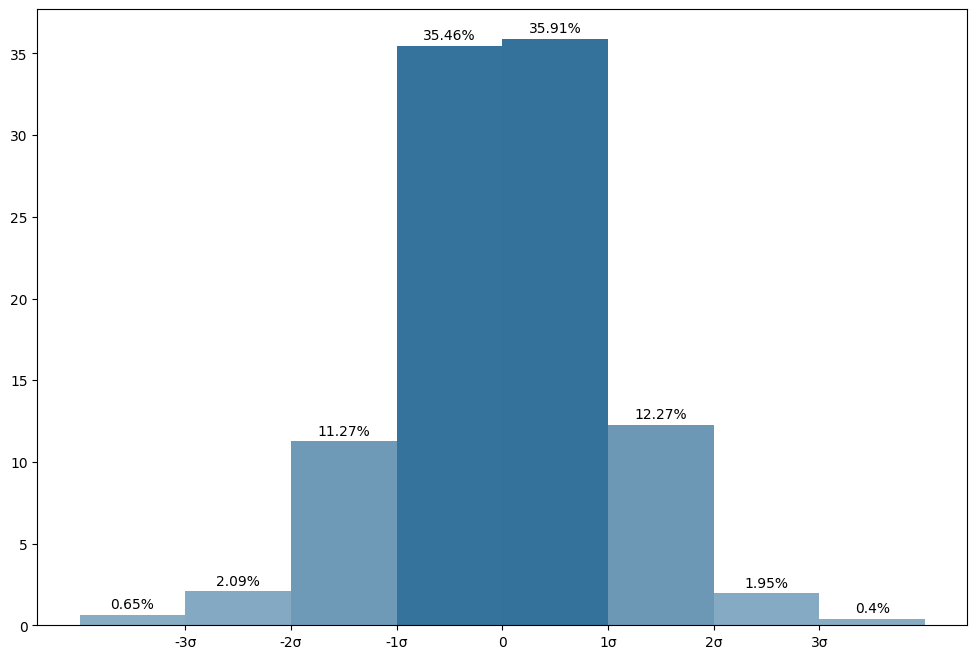

In [368]:
factor = 3
data = getErrorValues()
distribution = getDistributionByStdIntervals(data, factor)

showMarginOfErreur(distribution, factor)

print(distribution, sum(distribution))

res_q1 = getPercentageInterval(distribution, 1)
res_q2 = getPercentageInterval(distribution, 2)
res_q3 = getPercentageInterval(distribution, 3)

print("Question 2.1.1: Dans l'intervale [-σ; σ], il y a " + str(res_q1[0]) + "% des points")
print("\tQuestion 2.1.4: En dehors de cet intervale, il y a " + str(res_q1[1]) + "% des points\n")
print("Question 2.1.2: Dans l'intervale [-2σ; 2σ], il y a " + str(res_q2[0]) + "% des points")
print("\tQuestion 2.1.4: En dehors de cet intervale, il y a " + str(res_q2[1]) + "% des points\n")
print("Question 2.1.3: Dans l'intervale [-3σ; 3σ], il y a " + str(res_q3[0]) + "% des points")
print("\tQuestion 2.1.4: En dehors de cet intervale, il y a " + str(res_q3[1]) + "% des points\n")

### 2.2 - p-valeur

#### Pour obtenir ce résultat, Il faut combiné plusieurs foumule:

##### Probabilité d'obtenir exactament $k$ points ce situant du même côté par rapport a la moyenne dans $n$ essais:
ou $p$ correspond à la probabilité d'être dans le côté étudié, dans notre cas elle est de 50%

$$
P(X = k) = \binom{n}{k} p^k (1-p)^{n-k}
$$

##### Coefficient binomial
Représente le nombre de façons de choisir $k$ éléments distincts parmi un ensemble de $n$ éléments, sans tenir compte de l'ordre.

$$
\binom{n}{k} = \frac{n!}{k! (n-k)!}
$$

##### Probabilité d'obtenir au moins $k$ points ce situant du même côté par rapport a la moyenne dans $n$ essais:

$$
P(X \geq k) = \sum_{i=k}^n P(X = i)
$$

In [370]:
def factorial(n):
  res = 1
  for i in range(2, n+1):
    res *= i
  return res

def pExactlyKPointOutOfN(k, n, p):
  coefBi = factorial(n) / (factorial(k) * factorial(n - k))
  return coefBi * (p ** k) * ( (1 - p) ** (n - k) )

def pAtLestKPointOutOfN(k, n, p):
  res = 0
  for i in range(k, n + 1):
    res += pExactlyKPointOutOfN(i, n, p) 
  return round(res * 100, 2)

test_data = numpy.random.normal(size=(1, 1000000))[0]
test_p = getDistributionByStdIntervals(test_data, 3)

print("Application de la formule pour la probabilité qu'au moins 12 des 15 derniers points se situent au dessus de la moyenne:", pAtLestKPointOutOfN(12, 15, 0.5))
print("Application de la formule pour la probabilité qu'au moins 15 des 20 derniers points se situent au dessus de la moyenne:", pAtLestKPointOutOfN(15, 20, 0.5))
print("pValeur pour au moins 8 points sur les 10 derniers du même côté de la moyenne:", pAtLestKPointOutOfN(8, 10, 0.5))
print("pValeur pour au moins 2 points sur les 7 derniers en dehors de l'intervalle [-2σ; 2σ]:", pAtLestKPointOutOfN(2, 7, getPercentageInterval(test_p, 2)[1] / 100))
print("pValeur pour au moins 7 points sur les 10 derniers en dehors de l'intervalle [-σ; σ]:", pAtLestKPointOutOfN(7, 10, getPercentageInterval(test_p, 1)[1] / 100))


Application de la formule pour la probabilité qu'au moins 12 des 15 derniers points se situent au dessus de la moyenne: 1.76
Application de la formule pour la probabilité qu'au moins 15 des 20 derniers points se situent au dessus de la moyenne: 2.07
pValeur pour au moins 8 points sur les 10 derniers du même côté de la moyenne: 5.47
pValeur pour au moins 2 points sur les 7 derniers en dehors de l'intervalle [-2σ; 2σ]: 3.73
pValeur pour au moins 7 points sur les 10 derniers en dehors de l'intervalle [-σ; σ]: 1.48
